# First deep learning approach second challenge

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../")) #Add parent directory
from modules.utils import set_seed

SEED = 42
set_seed(SEED)

# Libraries

In [2]:
import torch
import numpy as np
from modules.data_loader_vit import get_data_loaders
from modules.model_vit import SkinLesionClassifier_VIT
from modules.train import train_model
from modules.utils import calculate_accuracy
from modules.visualize_aug import visualize_dataloader
from modules.plot_losses import plot_losses

# Connect to GPU

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

True
NVIDIA GeForce RTX 4060 Laptop GPU
Device: cuda


# Folder paths

In [4]:
tri_class_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\Computer_Aided_Diagnosis\Labs\Datasets\Tri".replace("\\","/")

train_dir = os.path.join(tri_class_path,"train/train").replace("\\","/")
val_dir = os.path.join(tri_class_path,"val/val").replace("\\", "/")

# Load data

In [6]:
batch_size = 32
train_loader, val_loader, test_loader = get_data_loaders(train_dir, val_dir, batch_size, seed = SEED)

Train set size: 5082
Validation set size: 635
Test set size: 635


In [7]:
from collections import Counter

def get_class_distribution(loader):
    class_counts = Counter()
    for batch in loader:
        image, label, _ = batch
        class_counts.update(label.numpy())
    return class_counts

print(f"Train class distribution: {get_class_distribution(train_loader)}")
print(f"Val class distribution: {get_class_distribution(val_loader)}")
print(f"Test class distribution: {get_class_distribution(test_loader)}")

Train class distribution: Counter({np.int64(1): 2713, np.int64(0): 1993, np.int64(2): 376})
Val class distribution: Counter({np.int64(1): 339, np.int64(0): 249, np.int64(2): 47})
Test class distribution: Counter({np.int64(1): 339, np.int64(0): 249, np.int64(2): 47})


Type of images: <class 'torch.Tensor'>
Type of labels: <class 'torch.Tensor'>
Type of paths: <class 'tuple'>


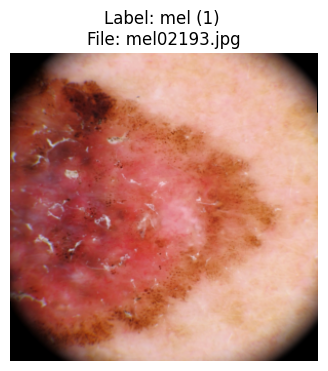

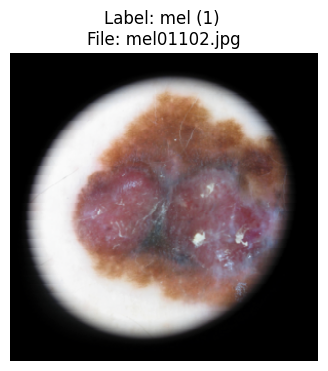

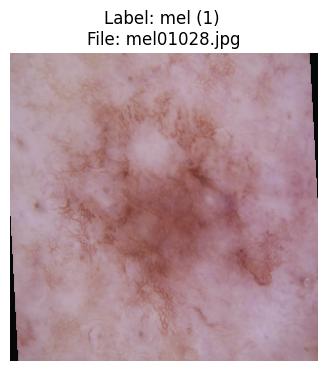

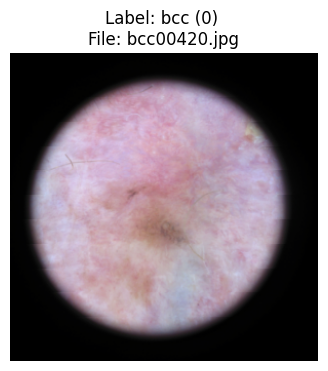

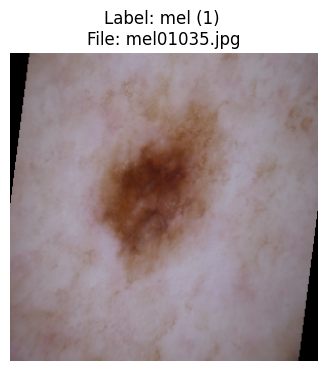

In [7]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
visualize_dataloader(train_loader, mean, std, 5)

# Initialize model

In [8]:
#Initialize model
model = SkinLesionClassifier_VIT(num_classes=3)
model

SkinLesionClassifier_EfficientNetB7(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=Tr

## Loss and optimizerv

Recommended settings for *scheduler*:
* mode='min' (to minimize validation loss).
* patience=3 (adjust based on how quickly your model stabilizes).
* factor=0.1 (reduce the learning rate by 10x when triggered).

In [9]:
num_epochs = 30
learning_rate = 1e-3
criterion = torch.nn.CrossEntropyLoss() #tHE OTHER ONE EXPECTS THE INPUT TO BE PASSED THROUGH A LOGIT BEFORE
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay=1e-4)


#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)
#Other schedulers
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, factor = 0.1)


#To try fpr visual transformer
# optimizer = torch.optim.AdamW([
#     {'params': model.model.encoder.parameters(), 'lr': 5e-5},
#     {'params': model.model.heads.parameters(), 'lr': 1e-3}
# ], weight_decay=1e-4)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

## Train the model

Some possible things to fix regarding the small fluctations:
 1) Learning rate: if it is too high, it could cause instability in optimization
 2) Validation Data Variance: Some inherit noise
 3) Optimization

# Generalization GAP

In [10]:
model, train_losses, val_losses = train_model(model,  train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, save_path ="tri_class_best_model_efficientB7_2_ReducePlatAdamW_4layers_30epochs.pth")
plot_losses(train_losses, val_losses)

Best model saved with val kappa: 0.6287 at epoch 1
Epoch 1 / 30 Training Loss: 0.5502 Validation Loss: 0.8538 Validation Kappa: 0.6287 LR: 0.0010000000
Best model saved with val kappa: 0.7381 at epoch 2
Epoch 2 / 30 Training Loss: 0.3965 Validation Loss: 0.4777 Validation Kappa: 0.7381 LR: 0.0010000000
Epoch 3 / 30 Training Loss: 0.3271 Validation Loss: 0.4233 Validation Kappa: 0.6810 LR: 0.0010000000
Epoch 4 / 30 Training Loss: 0.2728 Validation Loss: 0.4716 Validation Kappa: 0.6859 LR: 0.0010000000


KeyboardInterrupt: 

# Test on the partitioned validation set

In [11]:
model_best_res = SkinLesionClassifier_VIT(num_classes=3)
model_path = "tri_class_best_model_VIT_1_ReducePlatAdamW_8layers_30epochs.pth"
check_point = torch.load(model_path, map_location=device)
model_best_res.load_state_dict(check_point["model_state_dict"])

model_best_res.to(device)
model_best_res.eval()

C:\Users\User\AppData\Local\Temp\ipykernel_13920\3477424276.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(model_path, map_location=device)


SkinLesionClassifier_EfficientNetB7(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=Tr

635
635
Accuracy: 0.9496
Kappa Score: 0.9096
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       249
           1       0.97      0.94      0.96       339
           2       0.87      0.87      0.87        47

    accuracy                           0.95       635
   macro avg       0.93      0.93      0.93       635
weighted avg       0.95      0.95      0.95       635



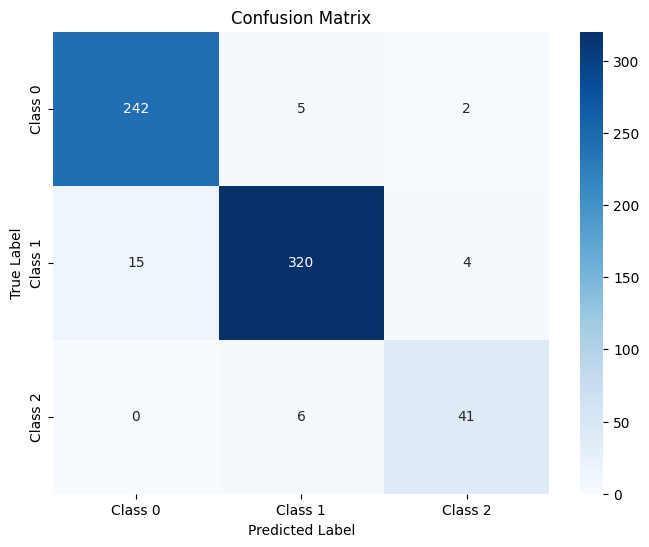

In [13]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
import numpy as np


all_preds = []
all_labels = []
with torch.no_grad():
        for inputs, labels, _ in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            outputs = model_best_res(inputs)

            # Collect predictions and labels
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

print(len(all_preds))
print(len(all_labels))

# Generate confusion matrix and metrics
cm = confusion_matrix(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)  # Calculate kappa score

print(f"Accuracy: {accuracy:.4f}")
print(f"Kappa Score: {kappa:.4f}")
print(classification_report(all_labels, all_preds))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix")
plt.show()


# Prediction over real test set and csv creation

Test set size: 2121
Type of images: <class 'torch.Tensor'>
Type of labels: <class 'torch.Tensor'>
Type of paths: <class 'tuple'>


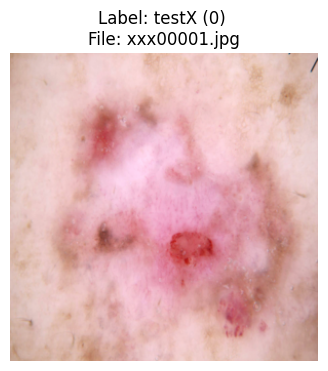

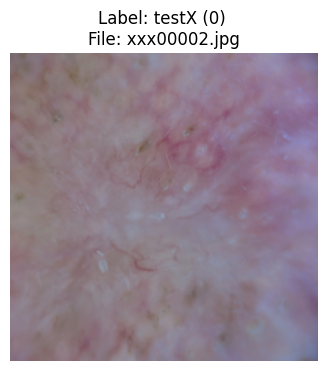

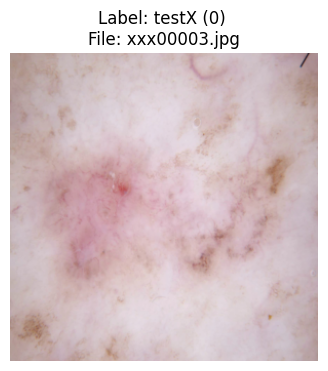

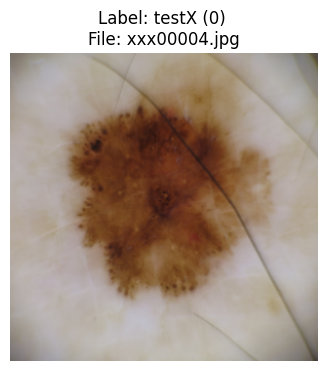

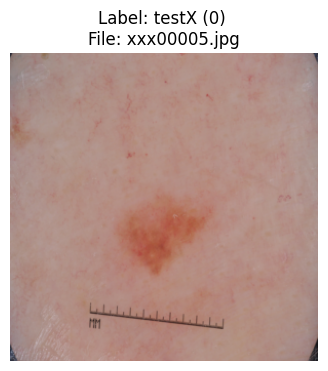

In [21]:
from modules.data_loader import get_data_loader_test
test_real_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\Computer_Aided_Diagnosis\Labs\Datasets\Tri\test".replace("\\","/")

test_real_loader = get_data_loader_test(test_real_path, batch_size=32)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
visualize_dataloader(test_real_loader, mean, std, 5)

# Make predictions

In [ ]:
import pandas as pd
import torch
import os
import numpy as np
from torch.nn.functional import softmax

# Put model in eval mode
model_best_res.eval()

predictions = []
filenames = []

with torch.no_grad():
    for inputs, _, paths in test_real_loader:
        # Move inputs to the appropriate device
        inputs = inputs.to(device)

        # Forward pass to get raw logits
        outputs = model_best_res(inputs)

        # Get predicted class (highest probability index)
        # For 3-class output, argmax returns 0,1,2
        class_preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Store predictions
        predictions.extend(class_preds)

        # Extract filenames from paths
        file_names = [os.path.basename(path) for path in paths]
        filenames.extend(file_names)

# Combine into DataFrame
results_df = pd.DataFrame({
    "filename": filenames,
    "prediction": predictions
})

# Optionally map numeric predictions to class names
# Suppose you have a dictionary for class mapping:
idx_to_class = {0: "class0", 1: "class1", 2: "class2"}

# results_df["class_name"] = results_df["prediction"].map(idx_to_class)

# Save CSV
csv_file = "test_predictions_VIT_multiclass.csv"
results_df.to_csv(csv_file, index=False)

print(f"Number of filenames: {len(filenames)}")
print(f"Number of predictions: {len(predictions)}")


Number of filenames: 2121
Number of predictions: 2121


In [19]:
print("outputs.shape:", outputs.shape)

outputs.shape: torch.Size([3])


# Arrange file in order

In [42]:
csv_file_original = csv_file
sorted_csv_file = "test_predictions_VIT_sorted.csv"

df = pd.read_csv(csv_file_original)

df_sorted = df.sort_values(by="filename")

df_sorted.to_csv(sorted_csv_file, index = False)

# Comparing results with previous results

In [25]:
def compare_predictions_with_similarity(excel_file, csv_file):
    """
    Compare predictions from an Excel file and a CSV file as they are,
    and calculate the similarity percentage between the two predictions.

    Args:
        excel_file: Path to the Excel file containing predictions in order.
        csv_file: Path to the CSV file containing filenames and predictions.

    Returns:
        None. Prints the similarity percentage and mismatch statistics.
    """
    # Load predictions from the Excel file
    excel_predictions = pd.read_excel(excel_file, header=None)[0]  # Read the first column (assumes no header)

    # Load predictions from the CSV file
    csv_predictions = pd.read_csv(csv_file)["prediction"]  # Extract the 'prediction' column

    # Ensure both columns have the same length
    if len(excel_predictions) != len(csv_predictions):
        print(f"Error: Mismatch in lengths. Excel: {len(excel_predictions)}, CSV: {len(csv_predictions)}")
        return

    # Compare predictions
    matches = excel_predictions == csv_predictions
    similarity_percentage = (matches.sum() / len(matches)) * 100

    # Output results
    print(f"Similarity Percentage: {similarity_percentage:.2f}%")
    if similarity_percentage < 100:
        mismatches = ~matches
        mismatch_indices = mismatches[mismatches].index
        print(f"Found {len(mismatch_indices)} mismatches.")
        print(f"Examples of mismatches (up to 5):")
        for idx in mismatch_indices[:5]:
            print(f"Row {idx + 1}: Excel={excel_predictions[idx]}, CSV={csv_predictions[idx]}")

# Example usage
excel_file = fr"C:\Users\User\GitHub_Projects\CAD_DL\CADx-Project\1_ML\Ch2\multiclass_results_final.xlsx".replace("\\","/")  # Replace with your Excel file path
csv_file = "test_predictions_efficientnet_multiclass.csv"  # Replace with your CSV file path

compare_predictions_with_similarity(excel_file, csv_file)


Similarity Percentage: 87.03%
Found 275 mismatches.
Examples of mismatches (up to 5):
Row 1: Excel=0, CSV=2
Row 21: Excel=2, CSV=0
Row 30: Excel=0, CSV=1
Row 41: Excel=0, CSV=2
Row 47: Excel=0, CSV=1
